# Classification Model

## Importing Libraries
In the cell below we will import all the libraries required in this project. We will be using following libraries

- **numpy**: It will be used to convert pandas dataframe into vector form, because Multi Layer Perceptrons (Neural Networks) required the input to be in vector form.
- **pandas**: It will be used to load/read the dataset from the csv file, we will use pandas to filter the dataset.
- **keras**: It will be used for building Neural Network. It is one of the best library to implement Neural Networks.
- **matplotlib**: For plotting graphs.
- **seaborn**: For plotting graphs. We have plotted the heatmap using seaborn library.


In [1]:
# Imports
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

np.random.seed(42)

----
# Loading dataset

## Loading Training dataset
First we will load training dataset. We will load dataset using pandas. With the help of `read_csv()` function we can easily read the csv files.

We have dropped some columns because we don't use them in our model. I have dropped `id`, `name`, `slug`, `path`, `description`, `version`, `competition-num`, `published`, `modified`, `links`, `link-tags`, `ratings-given` because they are not useful for our project, as we can see them they are not related with our project and if we use them they will create bias in the model which results in bad accuracy. 

I have dropped these columns `num-authors`, `prev-games`, `feedback-karma`, `audio-average`, `humor-average`, `audio-rank`, `humor-rank`, `num-comments`, `ratings-received` after correlation analysis because they all have less than 50% correlation result, so that's why they are not useful in our computation.

In [2]:
data = pd.read_csv('train.csv')

data = data.drop(['id', 'name', 'slug', 'path', 'description', 'version', 'competition-num', 'published', 'modified', 'links', 'link-tags', 'ratings-given', 'num-authors', 'prev-games', 'feedback-karma', 'audio-average', 'humor-average', 'audio-rank', 'humor-rank', 'num-comments', 'ratings-received'], axis=1)

data.replace(-1, 0, inplace=True)

data[:8]

,category,fun-average,innovation-average,theme-average,graphics-average,mood-average,fun-rank,innovation-rank,theme-rank,graphics-rank,mood-rank,label
0,jam,3.840,3.280,3.720,3.680,3.609,88,298,230,328,202,4
1,compo,3.519,3.815,4.037,3.815,3.692,147,61,55,136,83,4
2,jam,3.565,3.696,2.913,3.087,3.429,175,130,598,528,279,4
3,jam,3.550,2.700,3.100,4.000,3.400,180,600,536,190,290,4
4,compo,3.436,4.077,3.154,2.179,2.417,171,31,356,518,477,3
5,compo,3.333,4.467,3.793,3.967,3.929,196,2,117,94,43,4
6,jam,2.429,1.857,2.905,2.238,2.000,695,768,600,707,744,2
7,compo,3.250,2.865,3.194,3.135,3.343,226,367,349,301,181,4


## Loading Testing Dataset
We will load training dataset in the cell below and we will apply the same computations as we did with training dataset becuase training and testing dataset must have same features (columns).

In the cell below we will just save the `id` in a variable which will be helpful in saving the data in submission file.

In [3]:
# reading testing data
test_data = pd.read_csv('test.csv')

test_data_id = test_data["id"]

test_data = test_data.drop(['id', 'name', 'slug', 'path', 'description', 'version', 'competition-num', 'published', 'modified', 'links', 'link-tags', 'ratings-given', 'num-authors', 'prev-games', 'feedback-karma', 'audio-average', 'humor-average', 'audio-rank', 'humor-rank', 'num-comments', 'ratings-received'], axis=1)

test_data.replace(-1, 0, inplace=True)

test_data

,category,fun-average,innovation-average,theme-average,graphics-average,mood-average,fun-rank,innovation-rank,theme-rank,graphics-rank,mood-rank
0,compo,4.000,4.000,4.333,3.833,4.000,0,0,0,0,0
1,jam,2.577,2.654,3.577,3.577,3.308,0,0,0,0,0
2,jam,3.716,3.770,4.176,4.378,3.750,469,350,214,203,561
3,jam,3.250,3.000,3.250,2.750,3.000,0,0,0,0,0
4,compo,3.816,3.105,3.632,3.566,3.292,136,675,561,442,449
...,...,...,...,...,...,...,...,...,...,...,...
4954,compo,4.266,4.306,3.587,4.192,0.000,11,13,603,81,0
4955,compo,3.524,4.283,4.223,3.783,3.811,342,16,53,270,113
4956,jam,3.129,3.892,4.022,3.672,3.295,1627,214,477,1170,1408
4957,jam,4.000,4.169,4.306,4.484,4.226,140,62,79,115,96


---
# Preparing the Data
Before data can be used as input, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome. We use same techniques for both training and testing datasets.

### One Hot Encoding

We have one non-numeric feature `category`. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |


In [4]:
# Make dummy variables for rank
one_hot_data = pd.concat([data, pd.get_dummies(data['category'], prefix='category')], axis=1)

# Drop the previous rank column
one_hot_data = one_hot_data.drop('category', axis=1)

# Print the first 10 rows of our data
one_hot_data

,fun-average,innovation-average,theme-average,graphics-average,mood-average,fun-rank,innovation-rank,theme-rank,graphics-rank,mood-rank,label,category_compo,category_jam
0,3.840,3.280,3.720,3.680,3.609,88,298,230,328,202,4,0,1
1,3.519,3.815,4.037,3.815,3.692,147,61,55,136,83,4,1,0
2,3.565,3.696,2.913,3.087,3.429,175,130,598,528,279,4,0,1
3,3.550,2.700,3.100,4.000,3.400,180,600,536,190,290,4,0,1
4,3.436,4.077,3.154,2.179,2.417,171,31,356,518,477,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0,0,1
21944,2.888,3.127,2.833,4.252,3.604,376,287,420,24,114,3,1,0
21945,3.861,2.882,3.472,4.053,3.361,131,793,435,239,536,4,0,1
21946,3.227,3.273,2.286,4.543,3.727,578,484,1076,19,275,4,0,1


In [5]:
# Make dummy variables for rank
one_hot_test_data = pd.concat([test_data, pd.get_dummies(test_data['category'], prefix='category')], axis=1)

# Drop the previous rank column
one_hot_test_data = one_hot_test_data.drop('category', axis=1)

# Print the first 10 rows of our data
one_hot_test_data

,fun-average,innovation-average,theme-average,graphics-average,mood-average,fun-rank,innovation-rank,theme-rank,graphics-rank,mood-rank,category_compo,category_jam
0,4.000,4.000,4.333,3.833,4.000,0,0,0,0,0,1,0
1,2.577,2.654,3.577,3.577,3.308,0,0,0,0,0,0,1
2,3.716,3.770,4.176,4.378,3.750,469,350,214,203,561,0,1
3,3.250,3.000,3.250,2.750,3.000,0,0,0,0,0,0,1
4,3.816,3.105,3.632,3.566,3.292,136,675,561,442,449,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4954,4.266,4.306,3.587,4.192,0.000,11,13,603,81,0,1,0
4955,3.524,4.283,4.223,3.783,3.811,342,16,53,270,113,1,0
4956,3.129,3.892,4.022,3.672,3.295,1627,214,477,1170,1408,0,1
4957,4.000,4.169,4.306,4.484,4.226,140,62,79,115,96,0,1


### Spliting Labels in Training dataset 

In [6]:
features = one_hot_data.drop('label', axis=1)
label = one_hot_data['label']

print("Rows in label: ", label.shape[0])
features

Rows in label:  21948


,fun-average,innovation-average,theme-average,graphics-average,mood-average,fun-rank,innovation-rank,theme-rank,graphics-rank,mood-rank,category_compo,category_jam
0,3.840,3.280,3.720,3.680,3.609,88,298,230,328,202,0,1
1,3.519,3.815,4.037,3.815,3.692,147,61,55,136,83,1,0
2,3.565,3.696,2.913,3.087,3.429,175,130,598,528,279,0,1
3,3.550,2.700,3.100,4.000,3.400,180,600,536,190,290,0,1
4,3.436,4.077,3.154,2.179,2.417,171,31,356,518,477,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
21943,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0,1
21944,2.888,3.127,2.833,4.252,3.604,376,287,420,24,114,1,0
21945,3.861,2.882,3.472,4.053,3.361,131,793,435,239,536,0,1
21946,3.227,3.273,2.286,4.543,3.727,578,484,1076,19,275,0,1


## Scaling the data
The next step is to scale the data. We notice that the range for numerical features are much higher. This means our data is skewed, and that makes it hard for a neural network to handle. So now we will fit our numerical features into a range of 0-1, by dividing each column with its maximum value.

In [7]:
# Getting max values
max_fun_avg = np.amax(features["fun-average"])
max_innovation_avg = np.amax(features["innovation-average"])
max_theme_avg = np.amax(features["theme-average"])
max_graphics_average = np.amax(features["graphics-average"])
max_mood_avg = np.amax(features["mood-average"])
max_fun_rank = np.amax(features["fun-rank"])
max_inovation_rank = np.amax(features["innovation-rank"])
max_theme_rank = np.amax(features["theme-rank"])
max_graphics_rank = np.amax(features["graphics-rank"])
max_mood_rank = np.amax(features["mood-rank"])


print("Max fun avg: ", max_fun_avg)
print("Max innovation avg: ", max_innovation_avg)
print("Max theme avg: ", max_theme_avg)
print("Max graphics avg: ", max_graphics_average)
print("Max mood avg: ", max_mood_avg)
print("Max fun rank: ", max_fun_rank)
print("Max innovation rank: ", max_inovation_rank)
print("Max theme rank: ", max_theme_rank)
print("Max graphics rank: ", max_graphics_rank)
print("Max mood rank: ", max_mood_rank)

Max fun avg:  5.0
Max innovation avg:  5.0
Max theme avg:  5.0
Max graphics avg:  5.0
Max mood avg:  5.0
Max fun rank:  1283
Max innovation rank:  1280
Max theme rank:  1284
Max graphics rank:  1187
Max mood rank:  1133


In [8]:

# Dividing each feature with max value

features["fun-average"] = features["fun-average"]/max_fun_avg
features["innovation-average"] = features["innovation-average"]/max_innovation_avg
features["theme-average"] = features["theme-average"]/max_theme_avg
features["graphics-average"] = features["graphics-average"]/max_graphics_average
features["mood-average"] = features["mood-average"]/max_mood_avg

features["fun-rank"] = features["fun-rank"]/max_fun_rank
features["innovation-rank"] = features["innovation-rank"]/max_inovation_rank
features["theme-rank"] = features["theme-rank"]/max_theme_rank
features["graphics-rank"] = features["graphics-rank"]/max_graphics_rank
features["mood-rank"] = features["mood-rank"]/max_mood_rank

features[:10]

,fun-average,innovation-average,theme-average,graphics-average,mood-average,fun-rank,innovation-rank,theme-rank,graphics-rank,mood-rank,category_compo,category_jam
0,0.7680,0.6560,0.7440,0.7360,0.7218,0.068589,0.232813,0.179128,0.276327,0.178288,0,1
1,0.7038,0.7630,0.8074,0.7630,0.7384,0.114575,0.047656,0.042835,0.114575,0.073257,1,0
2,0.7130,0.7392,0.5826,0.6174,0.6858,0.136399,0.101562,0.465732,0.444819,0.246249,0,1
3,0.7100,0.5400,0.6200,0.8000,0.6800,0.140296,0.468750,0.417445,0.160067,0.255958,0,1
4,0.6872,0.8154,0.6308,0.4358,0.4834,0.133281,0.024219,0.277259,0.436394,0.421006,1,0
5,0.6666,0.8934,0.7586,0.7934,0.7858,0.152767,0.001563,0.091121,0.079191,0.037952,1,0
6,0.4858,0.3714,0.5810,0.4476,0.4000,0.541699,0.600000,0.467290,0.595619,0.656664,0,1
7,0.6500,0.5730,0.6388,0.6270,0.6686,0.176150,0.286719,0.271807,0.253580,0.159753,1,0
8,0.5450,0.4600,0.6628,0.4654,0.5160,0.471551,0.548438,0.347352,0.581297,0.590468,0,1
9,0.6172,0.6914,0.6572,0.6000,0.6530,0.237724,0.124219,0.238318,0.280539,0.187114,1,0


In [9]:
# Getting maximum
max_fun_avg_test = np.amax(one_hot_test_data["fun-average"])
max_innovation_avg_test = np.amax(one_hot_test_data["innovation-average"])
max_theme_avg_test = np.amax(one_hot_test_data["theme-average"])
max_graphics_average_test = np.amax(one_hot_test_data["graphics-average"])
max_mood_avg_test = np.amax(one_hot_test_data["mood-average"])
max_fun_rank_test = np.amax(one_hot_test_data["fun-rank"])
max_inovation_rank_test = np.amax(one_hot_test_data["innovation-rank"])
max_theme_rank_test = np.amax(one_hot_test_data["theme-rank"])
max_graphics_rank_test = np.amax(one_hot_test_data["graphics-rank"])
max_mood_rank_test = np.amax(one_hot_test_data["mood-rank"])


# Dividing the feature with maximum value
one_hot_test_data["fun-average"] = one_hot_test_data["fun-average"]/max_fun_avg_test
one_hot_test_data["innovation-average"] = one_hot_test_data["innovation-average"]/max_innovation_avg_test
one_hot_test_data["theme-average"] = one_hot_test_data["theme-average"]/max_theme_avg_test
one_hot_test_data["graphics-average"] = one_hot_test_data["graphics-average"]/max_graphics_average_test
one_hot_test_data["mood-average"] = one_hot_test_data["mood-average"]/max_mood_avg_test
one_hot_test_data["fun-rank"] = one_hot_test_data["fun-rank"]/max_fun_rank_test
one_hot_test_data["innovation-rank"] = one_hot_test_data["innovation-rank"]/max_inovation_rank_test
one_hot_test_data["theme-rank"] = one_hot_test_data["theme-rank"]/max_theme_rank_test
one_hot_test_data["graphics-rank"] = one_hot_test_data["graphics-rank"]/max_graphics_rank_test
one_hot_test_data["mood-rank"] = one_hot_test_data["mood-rank"]/max_mood_rank_test

one_hot_test_data[:10]

,fun-average,innovation-average,theme-average,graphics-average,mood-average,fun-rank,innovation-rank,theme-rank,graphics-rank,mood-rank,category_compo,category_jam
0,0.8000,0.8000,0.8666,0.7666,0.8000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0
1,0.5154,0.5308,0.7154,0.7154,0.6616,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
2,0.7432,0.7540,0.8352,0.8756,0.7500,0.184355,0.137417,0.084086,0.087575,0.235813,0,1
3,0.6500,0.6000,0.6500,0.5500,0.6000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
4,0.7632,0.6210,0.7264,0.7132,0.6584,0.053459,0.265018,0.220432,0.190682,0.188735,1,0
5,0.6324,0.7794,0.7538,0.5052,0.7102,0.607704,0.081665,0.380747,0.957722,0.386297,0,1
6,0.5900,0.5800,0.7700,0.6250,0.7000,0.766116,0.760110,0.310020,0.787317,0.412778,0,1
7,0.6736,0.6736,0.6000,0.7210,0.6578,0.441431,0.414998,0.871513,0.543141,0.594788,0,1
8,0.6292,0.5042,0.6876,0.6416,0.5876,0.620676,0.929329,0.665226,0.752804,0.811265,0,1
9,0.5600,0.6000,0.7166,0.8166,0.7286,0.000000,0.000000,0.000000,0.000000,0.000000,0,1


--------------------------------------------------------------------------------
## Correlation Analysis
Correlation analysis is use to find the associations between variables.The correlation coefficient is measured on a scale that varies from + 1 through 0 to - 1. Complete correlation between two variables is expressed by either + 1 or -1. When one variable increases as the other increases the correlation is positive; when one decreases as the other increases it is negative. Complete absence of correlation is represented by 0.

We are using pandas to calulate the correlation of a dataset, pandas function `.corr()` is used to calculate the correlation between features. There are 3 methods which can be used to calculate the correlation between features. we are using a standard one `Pearson method`, other two methods are `kendall` and `spearman`.

In [10]:
corr_analysis = features.corr(method="pearson")
corr_analysis

,fun-average,innovation-average,theme-average,graphics-average,mood-average,fun-rank,innovation-rank,theme-rank,graphics-rank,mood-rank,category_compo,category_jam
fun-average,1.000000,0.912164,0.889380,0.768898,0.770199,0.211794,0.287858,0.310399,0.295066,0.273874,0.060651,-0.060651
innovation-average,0.912164,1.000000,0.908111,0.739043,0.752736,0.268583,0.188747,0.267922,0.295563,0.268623,0.072144,-0.072144
theme-average,0.889380,0.908111,1.000000,0.731291,0.738532,0.279432,0.253272,0.174987,0.297782,0.276286,0.075400,-0.075400
graphics-average,0.768898,0.739043,0.731291,1.000000,0.721730,0.223690,0.254677,0.267385,0.257366,0.200804,0.043530,-0.043530
mood-average,0.770199,0.752736,0.738532,0.721730,1.000000,0.275628,0.284437,0.302923,0.240288,0.300979,0.000292,-0.000292
fun-rank,0.211794,0.268583,0.279432,0.223690,0.275628,1.000000,0.822241,0.771680,0.721726,0.763302,-0.178932,0.178932
innovation-rank,0.287858,0.188747,0.253272,0.254677,0.284437,0.822241,1.000000,0.826851,0.682958,0.736823,-0.178057,0.178057
theme-rank,0.310399,0.267922,0.174987,0.267385,0.302923,0.771680,0.826851,1.000000,0.651463,0.687851,-0.177879,0.177879
graphics-rank,0.295066,0.295563,0.297782,0.257366,0.240288,0.721726,0.682958,0.651463,1.000000,0.761260,-0.134081,0.134081
mood-rank,0.273874,0.268623,0.276286,0.200804,0.300979,0.763302,0.736823,0.687851,0.761260,1.000000,-0.178742,0.178742


## Plotting heatmap
The cell below will generate the heatmap for the corrleation analysis, this will helps us in visualizing the results. For plotting the heatmap we will be using `Seaborn` library function `.heatmap()`, this function takes the information about the correlation analysis and heat map colour is given in `cmap` parameter.

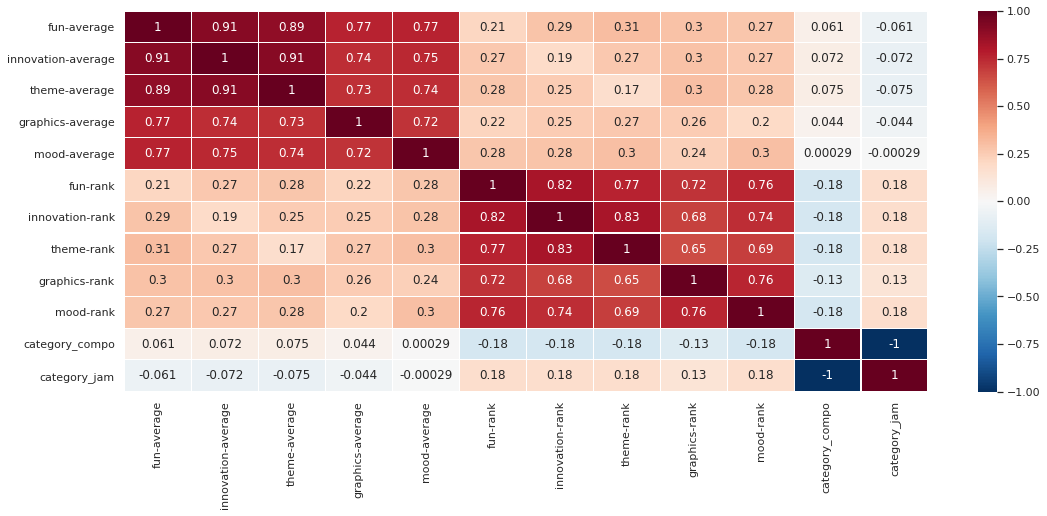

In [11]:
sb.set(rc={"figure.figsize":(18, 7)})
sb.heatmap(corr_analysis, 
            xticklabels=corr_analysis.columns,
            yticklabels=corr_analysis.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.1)

With the help of the heatmap we can easily visualize our corrleation analysis and we can tell which feature we have to use and which one we have to drop

---
## Converting data into vectors
In the cell below we will convert the input features into vectors. 

Also, in Keras, we need to one-hot encode the output. We'll do this with the `to_categorical function`. Remember we have 6 classes which we have to predict so then our vector will have 6 columns and each column represent each class. like `[0. 0. 0. 0. 1. 0.]` represents the output will be 4 (related to 4th class), similarly `[0. 0. 1. 0. 0. 0.]` will output 2.

In [12]:
# Separate data and one-hot encode the output
# Note: We're also turning the data into numpy arrays, in order to train the model in Keras
final_features = np.array(features)
final_label = np.array(keras.utils.to_categorical(label, 6))


print(final_features[:2])
print(final_label[:10])

[[0.768      0.656      0.744      0.736      0.7218     0.06858924
  0.2328125  0.17912773 0.27632687 0.17828773 0.         1.        ]
 [0.7038     0.763      0.8074     0.763      0.7384     0.11457521
  0.04765625 0.04283489 0.11457456 0.07325684 1.         0.        ]]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


Same computation with testing features

In [13]:
# Separate data and one-hot encode the output
# Note: We're also turning the data into numpy arrays, in order to train the model in Keras
final_test_features = np.array(one_hot_test_data)

print(final_test_features[:2])

[[0.8    0.8    0.8666 0.7666 0.8    0.     0.     0.     0.     0.
  1.     0.    ]
 [0.5154 0.5308 0.7154 0.7154 0.6616 0.     0.     0.     0.     0.
  0.     1.    ]]


In the cell below we will check the shape of input features, this is important becuase we have to mention the input shape in the first layer of Neural Network in keras

In [14]:
final_features.shape

(21948, 12)

----
## Building Model
Now in the cell below we will define our model architecture. In keras first we have to define the model architecture and then we can compile that and run tests on it. 

- **Sequential** class is used to initialize the mode.
- **add function** will add a layer to oour Neural Network model
- **Dense** class used for initializing a layer, in this we have to mention few things which are number of nodes in the layer, activation function for the layer and we will only define the input shape in the first layer of our Neural Network model further keras will handle everything for us. Defining input shape is simple we have to tell the model how many columns/features we have so then it will connect all the input features with the nodes in the layer.
- **Droput** class for initializing a dropout layer, this will help in the prevention of overfitting
- **Compile** function will compile the defined architecture for us, in this function we have to define the loss function, optimizer and metrics which will be used by our Neural Network model. **Note** by changining loss function and optimizer will effect the accuracy of the model.
- **summary** function will print the summary of the model.
- You can check different optimizers and loss functions on keras documentations


In [15]:
# Building the model
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(features.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(512, activation="tanh"))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              13312     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

---
## Training Model with Cross Validation
Now we will train our model with cross validation, cross validation will prevent overfitting and will help the model to learn in a better way

- **ModelCheckpoint** class will save the best weights for us in a file, which will use later.
- **fit** function will train the model for us, we have to give some parameters in the function, we have to pass the **features**, **labels**, **batch_size**, **epochs**, **validation_spilt**, and a callback function to save the weights for us

In [16]:
# Training the model with validation set
from keras.callbacks import ModelCheckpoint

# train the model
checkpointer = ModelCheckpoint(filepath='game.mode.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(final_features, final_label, batch_size=100, epochs=20, validation_split=0.2, callbacks=[checkpointer], verbose=1, shuffle=True)

Epoch 1/20
174/176 [============================>.] - ETA: 0s - loss: 0.3310 - accuracy: 0.8771
Epoch 00001: val_loss improved from inf to 0.20334, saving model to game.mode.best.hdf5
176/176 [==============================] - 7s 39ms/step - loss: 0.3300 - accuracy: 0.8772 - val_loss: 0.2033 - val_accuracy: 0.9203
Epoch 2/20
175/176 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9096
Epoch 00002: val_loss improved from 0.20334 to 0.18760, saving model to game.mode.best.hdf5
176/176 [==============================] - 5s 29ms/step - loss: 0.2196 - accuracy: 0.9097 - val_loss: 0.1876 - val_accuracy: 0.9219
Epoch 3/20
176/176 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.9146
Epoch 00003: val_loss improved from 0.18760 to 0.17719, saving model to game.mode.best.hdf5
176/176 [==============================] - 6s 34ms/step - loss: 0.2020 - accuracy: 0.9146 - val_loss: 0.1772 - val_accuracy: 0.9241
Epoch 4/20
175/176 [========================

---
## Testing model with testing dataset
Now after training we will test the model by providing the testing dataset features. For testing the model **predict_classes** function help us out, we just have to pass the testing features in that function and it will return the predicted classes. 

In [17]:
result = model.predict_classes(final_test_features, verbose=1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
155/155 [==============================] - 1s 7ms/step


---
## Saving result in submission file
Now we will save the data in submission file. we will save the data by the help of **csv** library. 

In [18]:
import csv
with open('new_submission2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id", "label"])
    for label_id, label_data in zip(test_data_id, result):
        writer.writerow([label_id, label_data])